In [101]:
from raphtory import Graph, graphql, PersistentGraph

import raphtory as rp
import pandas as pd
from utils import merge_intervals
from datetime import datetime as dt

import matplotlib.pyplot as plt

In [116]:
rp.__version__

'0.16.1'

**Raphtory** is a temporal network and analytics tool, written in Rust, but you can interact with it using:

- Python APIs.
- GraphQL: you can start a GraphQL server to interact with your networks
- Raphtory UI: WebUI interacting with the GraphQL server


# Ingest temporal networked data

You can build graphs directly in Raphtory or import data in standard formats.

Here, we import temporal data from a raw data source, a CSV file, convert it into a Pandas DataFrame and leverage the import function to load the data into a temporal network. Data come from the experiment conducted in the paper [V. Gelardi, J. Godard, D. Paleressompoulle, N. Claidière, A. Barrat, “Measuring social networks in primates: wearable sensors vs. direct observations”, Proc. R. Soc. A 476:20190737 (2020)](https://royalsocietypublishing.org/doi/10.1098/rspa.2019.0737) and are available in the [SocioPatterns repository](http://www.sociopatterns.org/datasets/baboons-interactions/).


In [10]:
interactions_df = pd.read_csv('data/OBS_data.txt',
                              sep = '\t',
                              header = 0,
                              usecols = [0,1,2,3,4],
                              dayfirst = True,
                              parse_dates = [0]
                )
interactions_df.dropna(axis=0, inplace = True)
interactions_df["Weight"] = interactions_df['Category'].apply(
    lambda c: 1 if (c == 'Affiliative') else (-1 if (c == 'Agonistic') else 0)
)
interactions_df

,DateTime,Actor,Recipient,Behavior,Category,Weight
15,2019-06-13 09:50:00,ANGELE,FELIPE,Grooming,Affiliative,1
17,2019-06-13 09:50:00,ANGELE,FELIPE,Grooming,Affiliative,1
19,2019-06-13 09:51:00,FELIPE,ANGELE,Resting,Affiliative,1
20,2019-06-13 09:51:00,FELIPE,LIPS,Resting,Affiliative,1
21,2019-06-13 09:51:00,ANGELE,FELIPE,Grooming,Affiliative,1
...,...,...,...,...,...,...
5370,2019-07-10 11:02:00,ARIELLE,LIPS,Touching,Affiliative,1
5371,2019-07-10 11:05:00,LIPS,NEKKE,Playing with,Affiliative,1
5372,2019-07-10 11:05:00,LIPS,FELIPE,Resting,Affiliative,1
5373,2019-07-10 11:05:00,LIPS,NEKKE,Resting,Affiliative,1


As we can see the dataset captures the interactions among a population of primates. In this example we do not consider the duration of the interactions (later we introduce the Raphtory class to support interval graphs).

From a DataFrame, we can create a Raphtory Graph through the method `load_edges_from_pandas`.

In [12]:
## Temporal Network Creation
temp_net = rp.Graph() # empty graph
temp_net.load_edges_from_pandas(
    df = interactions_df,
    src = 'Actor',
    dst = 'Recipient',
    time = 'DateTime',
    layer_col = 'Behavior',
    properties = ['Weight']
)
temp_net

Graph(number_of_nodes=22, number_of_edges=290, number_of_temporal_edges=3196, earliest_time=1560419400000, latest_time=1562756700000)

From the above snippet, we highlight three elements:

- **Only directed links**: All graphs in Raphtory are directed. When we add a temporal link we are specifying the source node the edge starts from and the destination node the edge ends at, at time $t$.
- **Multilayer network**: Raphtory also allows you to represent totally different relationships between the same nodes via `edge layers`. Each edge has a special attribute `layers` which stores the sequences of interactions of the layers the link is in.
- **Attributed network**: Raphtory can maintain the changing value of `Properties` associated with nodes and edges. Properties is a dictionary of key-value pairs to be stored at the given timestamp.

## Raphtory UI
To interact with the temporal network with a more visual approach we have to:

1. Create a GraphServer and client by defining a working directory.
2. Start the server and get a `RaphtoryClient`.
3. Send the relevant graphs to this client (in this case you only have one graph available).

In [14]:
server = graphql.GraphServer('graphql_server/')
client = server.start().get_client()

  2025-09-06T07:56:27.837441Z  INFO raphtory_graphql::server: Playground live at: http://0.0.0.0:1736
    at raphtory-graphql/src/server.rs:208



In [15]:
client.send_graph('Primates_tempnet', temp_net, overwrite = True)

# Interval Graph

In the previous section, we utilized the link stream representation without considering the durations of the interactions, i.e., we only focused on events thought of as instantaneous. To enable persistent interactions, i.e., events with a duration, Raphtory provides an additional graph representation where edges can be added, removed, and added back again, called the `PersistentGraph`. The `PersistenGraph` implements the Interval Graph representation (see slides).

To insert interactions with a duration, Raphtory adopts an approach less intuitive w.r.t. a simple link insertion requiring the start and the end points of the intervals. For instance,
``` python
g.add_edge('A','B', start = 3, end = 5)
```

Since the Raphtory's model is based on a sequence of events, to add an ''interval'' link, we have to add to link event:
- link insertion at a timestamp $t_{start}$
- link removal at a timestamp $t_{end}$

Here we leverage the methods in Pandas to deal with timestamp and deltatime. We add a new column -`EndTime`-to the DataFrame and leverage the methods of `PersistentGraph` class: 

- `load_edges_from_pandas`
- `load_edge_deletions_from_pandas`

In [80]:
interactions_df = pd.read_csv(
    'data/OBS_data.txt',
    sep = '\t',
    header = 0,
    usecols = [0,1,2,3,4,5],
    dayfirst = True,
    parse_dates = [0]
)
interactions_df.dropna(axis=0, inplace = True)
interactions_df['Weight'] = interactions_df['Category'].apply(
    lambda c: 1 if (c == 'Affiliative') else (-1 if (c == 'Agonistic') else 0)
)
interactions_df['EndTime'] = interactions_df["DateTime"] + pd.to_timedelta(interactions_df["Duration"], unit="m")
interactions_df['start'] = interactions_df["DateTime"].astype("int64") // 10**6
interactions_df['end'] = interactions_df["EndTime"].astype("int64") // 10**6
# For each distinct triple (actor, recipient, behavior)
# 1. build the list of intervals
# 2. make the union of the intervals so that we get a set of disjoint intervals in ascending order -> depends on how Raphtory handles the insertion of intervals
interval_data = (interactions_df.groupby(["Actor", "Recipient", "Behavior"], as_index=False)
    .agg(Intervals=("start", lambda s: merge_intervals(list(zip(s, interactions_df.loc[s.index, "end"])))))
    .reset_index()
)
tmp = interval_data.explode("Intervals").reset_index(drop=True)
intervals_df = pd.DataFrame(tmp["Intervals"].tolist(), columns=["start", "end"])
interactions_df = pd.concat([tmp.drop(columns="Intervals"), intervals_df], axis=1)

Creation of the `PersistentGraph`

In [81]:
interval_graph = PersistentGraph()
interval_graph.load_edges_from_pandas(
    df = interactions_df,
    src = 'Actor',
    dst = 'Recipient',
    time = 'start',
    layer_col = 'Behavior'
)
interval_graph.load_edge_deletions_from_pandas(
    df = interactions_df,
    src = 'Actor',
    dst = 'Recipient',
    time = 'end',
    layer_col = 'Behavior'
)

In [82]:
interval_graph

Graph(number_of_nodes=22, number_of_edges=290, number_of_temporal_edges=2052, earliest_time=1560419400000, latest_time=1562772720000)

In [91]:
for e in interval_graph.edge("FELIPE", "ANGELE").explode_layers():
    e_history = [date.timestamp() for date in e.history_date_time()]
    print(f"{e.src.name} interacted with {e.dst.name} with the following behaviour '{e.layer_name}' at this times: {e_history}:{len(e_history)}")

FELIPE interacted with ANGELE with the following behaviour 'Resting' at this times: [1560419460.0, 1560437460.0, 1560506760.0, 1560769320.0, 1560865320.0, 1560935520.0, 1561029420.0, 1561117740.0, 1561373880.0, 1561390860.0, 1562321400.0, 1562331720.0, 1562586360.0, 1562671020.0, 1562754600.0]:15
FELIPE interacted with ANGELE with the following behaviour 'Embracing' at this times: [1560526320.0]:1
FELIPE interacted with ANGELE with the following behaviour 'Presenting' at this times: [1562321580.0]:1
FELIPE interacted with ANGELE with the following behaviour 'Grunting-Lipsmacking' at this times: [1560526320.0, 1561972860.0, 1562253540.0]:3
FELIPE interacted with ANGELE with the following behaviour 'Supplanting' at this times: [1561110180.0]:1
FELIPE interacted with ANGELE with the following behaviour 'Mounting' at this times: [1562253540.0]:1
FELIPE interacted with ANGELE with the following behaviour 'Submission' at this times: [1562057520.0]:1
FELIPE interacted with ANGELE with the fol

# Sequence of graphs

In Raphtory, `Graph Views` provide a way to look at a subset of this data without having to re-ingest it. By `Graph Views`, we can decompose the evolution of a temporal network into snapshots. Moreover, the Raphtory's design provides that all functions that can be called on a graph, node, or edge can also be applied to a Graph View.

Raphtory provides six functions: `before()`, `at()`, `after()`, `window()`, `expand()` and `rolling()` for traveling through time and viewing a graph as it was at a specific point, or between two points (applying a time window). All of these functions can be **called on a graph, node, or edge**, returning an equivalent Graph View, Node View or Edge View.

To get a sequence of Graph Views, the primitive function is `window()`. This is a more general version of the functions `before()`, `at()`, `after()`, allowing to set both a `start` time as well as an `end` time, inclusive of the start and exclusive of the end time.

In [95]:
start_day = dt.strptime("2019-06-13", "%Y-%m-%d")
end_day = dt.strptime("2019-06-14", "%Y-%m-%d")
snapshot_1 = interval_graph.window(start_day, end_day)
snapshot_1

Graph(number_of_nodes=19, number_of_edges=77, number_of_temporal_edges=117, earliest_time=1560419400000, latest_time=1560460200000)

Finally, we obtain a sequence of snapshot graphs by the function `rolling()`. You can use rolling() to create a rolling window. This function will return an iterable of views, incrementing by a window size and only including the history from inside the window period, inclusive of start, exclusive of end. This allows you to easily extract daily or monthly metrics.

In [98]:
for snapshot in interval_graph.rolling('1 day'):
    print(snapshot)

Graph(number_of_nodes=19, number_of_edges=87, number_of_temporal_edges=137, earliest_time=1560419400000, latest_time=1560505680000)
Graph(number_of_nodes=20, number_of_edges=71, number_of_temporal_edges=103, earliest_time=1560505800000, latest_time=1560542040000)
Graph(number_of_nodes=0, number_of_edges=0, number_of_temporal_edges=0, earliest_time=None, latest_time=None)
Graph(number_of_nodes=8, number_of_edges=8, number_of_temporal_edges=9, earliest_time=1560764340000, latest_time=1560764820000)
Graph(number_of_nodes=19, number_of_edges=67, number_of_temporal_edges=106, earliest_time=1560765000000, latest_time=1560851340000)
Graph(number_of_nodes=18, number_of_edges=78, number_of_temporal_edges=133, earliest_time=1560851400000, latest_time=1560937680000)
Graph(number_of_nodes=19, number_of_edges=63, number_of_temporal_edges=84, earliest_time=1560937800000, latest_time=1560963120000)
Graph(number_of_nodes=20, number_of_edges=70, number_of_temporal_edges=105, earliest_time=1561024800000

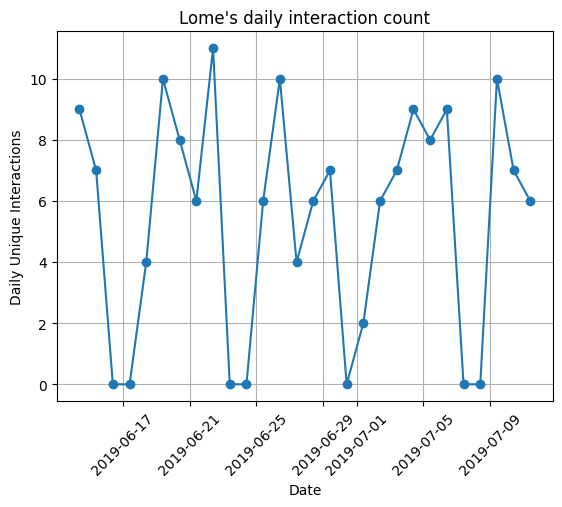

In [103]:
importance = []
time = []
for rolling_lome in interval_graph.node("LOME").rolling("1 day"):
    importance.append(rolling_lome.degree())
    time.append(rolling_lome.end_date_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Daily Unique Interactions")
plt.title("Lome's daily interaction count")
plt.grid(True)

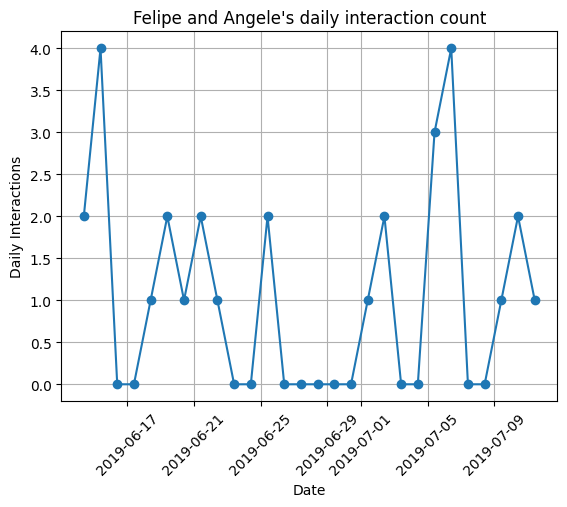

In [115]:
time = []
num_interactions = []
for interaction_snapshot in interval_graph.edge('FELIPE','ANGELE').rolling('1 day'):
    num_interactions.append(len(interaction_snapshot.explode()))
    time.append(interaction_snapshot.end_date_time)
plt.plot(time, num_interactions, marker="o")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Daily Interactions")
plt.title("Felipe and Angele's daily interaction count")
plt.grid(True)